# Researching Popular Data Science Questions in Stack Exchange

## Table of Contents
* [Introduction](#Introduction)
* [Summary](#Summary)
* [Background/Research](#Initial-Database-Queries)
* [Data Cleaning](#Data-Cleaning)
* [Data Visualization](#Data-Visualization)
* [Analyzing All Quesitons](#Analyzing-All-Quesitons)
* [Conclusion](#Conclusion)

# Introduction

We will be reviewing the [Stack Exchange Data Science database](https://data.stackexchange.com/datascience/query/new) to determine the most popular Data Science questions for a data science content creation company. The goal is to find the most popularly asked questions about data science so the content creation comapany will be able to make an informed decision about what the most useful type of content will be for its consumers.

## Summary

The most popular content over the years have been related to topics in deep learning, and that trend hasn't slowed over time. Therefore, it would be wise for the company create more content about deep learning.

## Initial Database Queries
The stack exchange database contains a myriad of different tables. There are many different tables containing data on the posts themselves, links in the posts, and comments on the posts. There are also tables dedicated to the tags on the posts. Specifically, the tables `Tags`, `CreationDate`, `Score`, `ViewCount`, `Id`, `AnswerCount`, and `FavoriteCount`. Of note, the Stack Exchange database must be queried in Transact-SQL, so all of the below code querying the database will be in that language.

To begin our analysis, we will run a query in the Databse that extracts the number of questions asked in the year 2019. To do this, we run the following code:


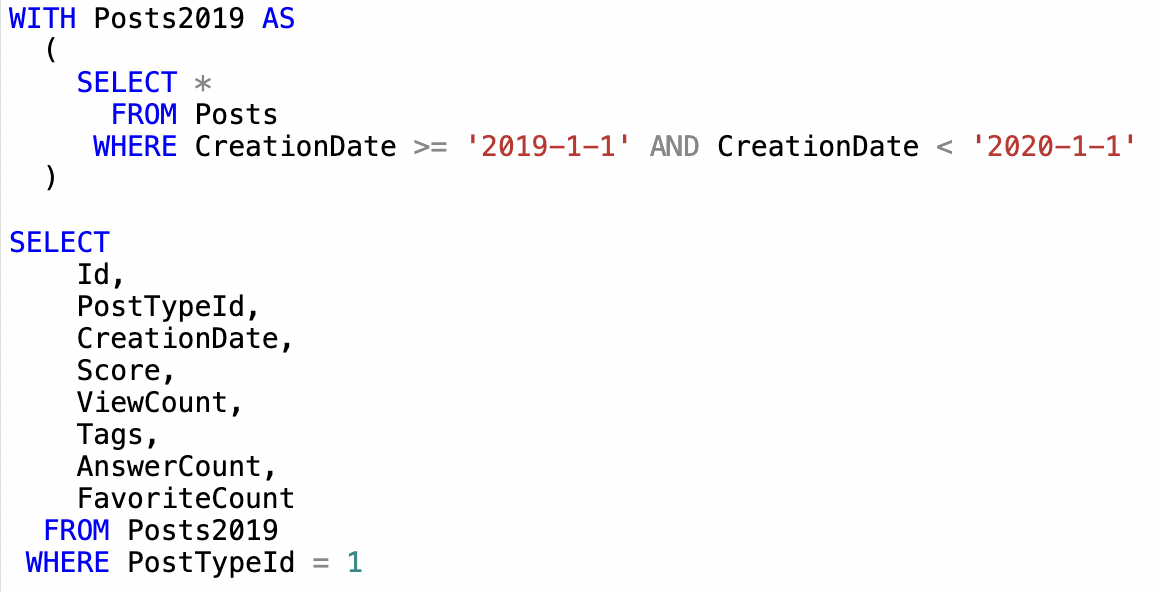

This code produces the following output:

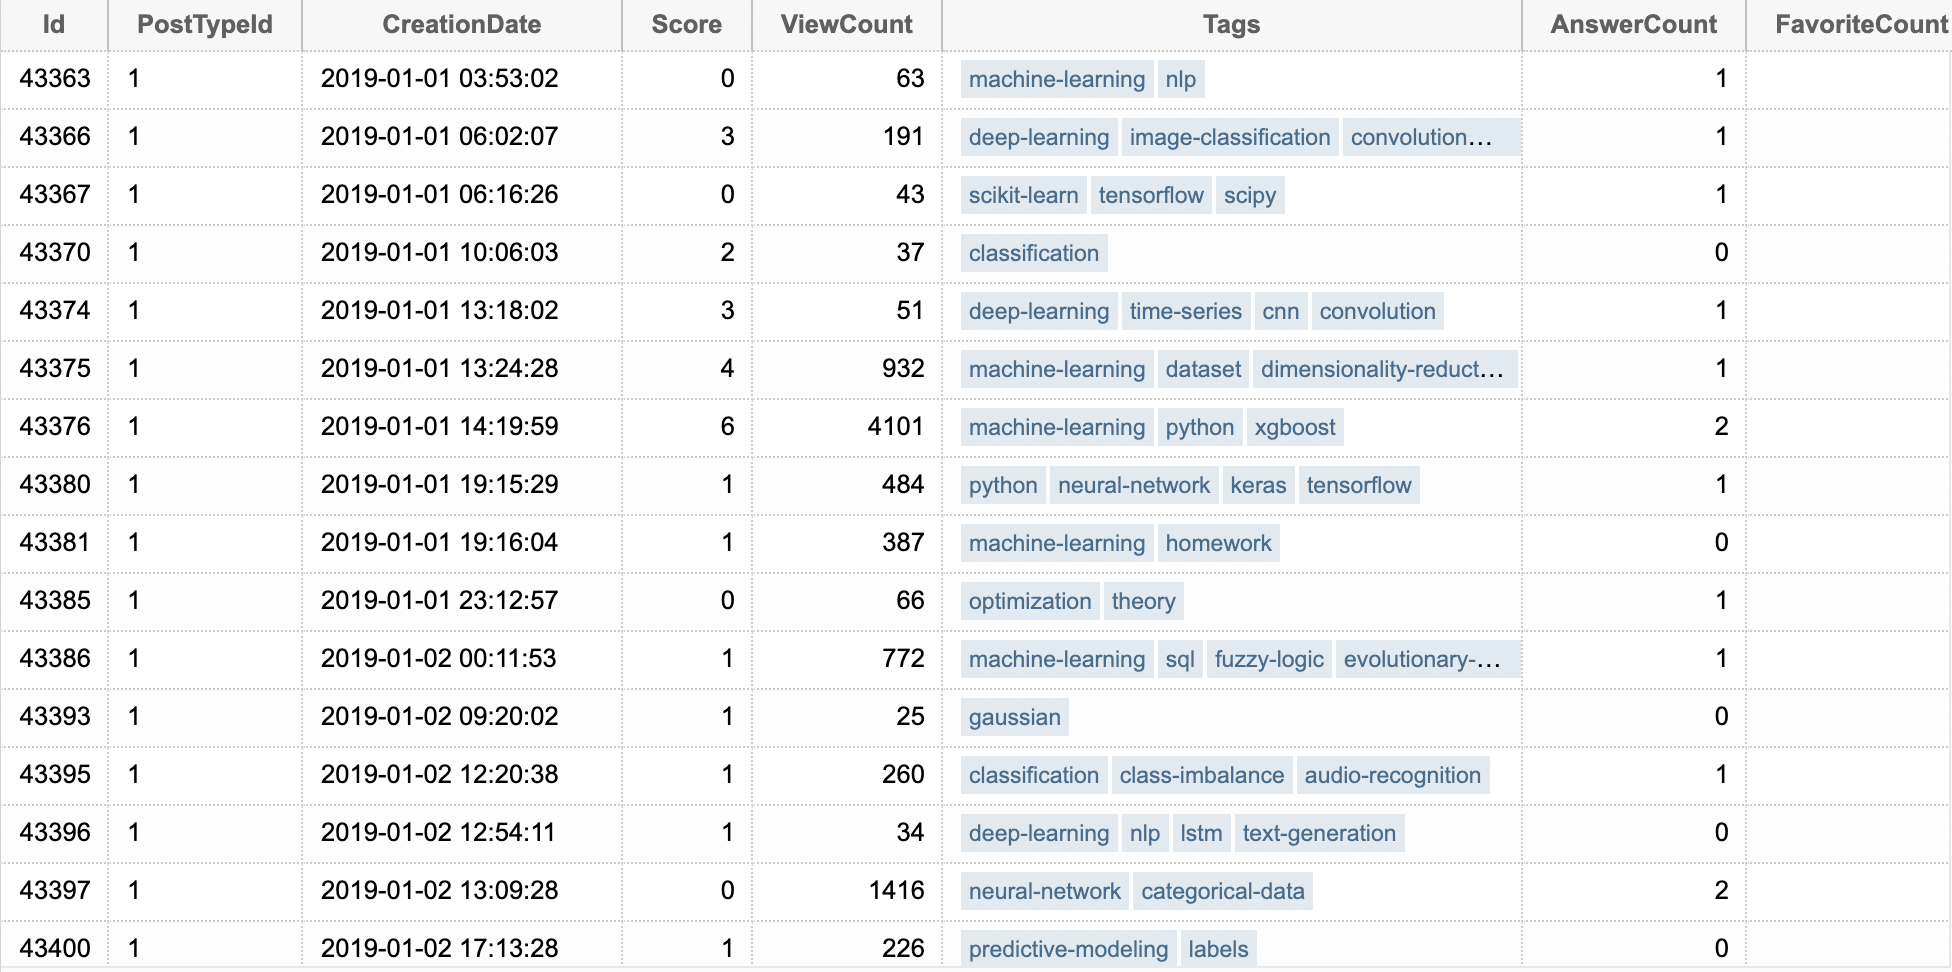

## Data Cleaning

We now have a query containing all the data we requested on questions asked in 2019. One thing we see immediately is that there are a lot of missing values in the column `FavoriteCount`. To see if anything else is wrong with the data, we will store it as a file `posts_2019.csv` and read it in as a pandas dataframe.

In [1]:
# Importing libraries we'll need for analysis
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
# Enables notebook's plotting capabilites
%matplotlib inline

In [2]:
# Reading in dataframe and printing head to ensure it loaded correctly
posts_2019 = pd.read_csv('/Users/ryanehrhardt/Downloads/posts_2019.csv')
print(posts_2019.head())

      Id  PostTypeId         CreationDate  Score  ViewCount  \
0  43363           1  2019-01-01 03:53:02      0         63   
1  43366           1  2019-01-01 06:02:07      3        191   
2  43367           1  2019-01-01 06:16:26      0         43   
3  43370           1  2019-01-01 10:06:03      2         37   
4  43374           1  2019-01-01 13:18:02      3         51   

                                                Tags  AnswerCount  \
0                            <machine-learning><nlp>            1   
1  <deep-learning><image-classification><convolut...            1   
2                  <scikit-learn><tensorflow><scipy>            1   
3                                   <classification>            0   
4     <deep-learning><time-series><cnn><convolution>            1   

   FavoriteCount  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  


Now that we have successfully loaded in our dataframe `posts_2019`, we will begin analyzing it to see what issues exist. We will start by counting the null values in each column of the dataframe.

In [3]:
# Displaying how many null values 
print(posts_2019.isnull().sum())

Id                  0
PostTypeId          0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    6588
dtype: int64


We can see that `FavoriteCount` is the only series in the dataframe with missing values. Since `FavoriteCount` logs the number of times each post has been favorited, we'll assume the null values are posts with no favorites and fill the missing values with zero.

In [4]:
posts_2019['FavoriteCount'] = posts_2019['FavoriteCount'].fillna(0)
print(posts_2019['FavoriteCount'].head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: FavoriteCount, dtype: float64


Now that we have filled each null value in the dataframe, we'll now examine the datatypes of each series in the `posts_2019`.

In [5]:
# Printing datatypes of each column for inspection
print(posts_2019.dtypes)

Id                 int64
PostTypeId         int64
CreationDate      object
Score              int64
ViewCount          int64
Tags              object
AnswerCount        int64
FavoriteCount    float64
dtype: object


We can see that most columns are integers, but `CreationDate` and `Tags` are `object` types, and `FavoriteCount` is a float type. We will want to change the `CreationDate` series to a `datetime` type and `FavoriteCount` to a float.

In [6]:
# Converting `CreationDate` to datetime and `FavoriteCount` to integer data types
posts_2019['CreationDate'] = pd.to_datetime(posts_2019['CreationDate'])
posts_2019['FavoriteCount'] = posts_2019['FavoriteCount'].notnull().astype(int)
# Display updated datatypes
print(posts_2019.dtypes)

Id                        int64
PostTypeId                int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object


Now that we have the datatypes we want for each series, we will continue cleaning the dataframe by updating the `Tags` column to a more useable format.

In [7]:
# Modifies string to more workable format and displays first five rows to ensure changes were successful
posts_2019['Tags'] = posts_2019['Tags'].str[0:-1].str.replace('<','').str.replace('>',',')
print(posts_2019['Tags'].head())

0                                 machine-learning,nlp
1    deep-learning,image-classification,convolution...
2                        scikit-learn,tensorflow,scipy
3                                       classification
4            deep-learning,time-series,cnn,convolution
Name: Tags, dtype: object


We have now changed the `Tags` series to a more workable format. We'll now count which tags were the most used by splitting the series `Tags` 

In [8]:
# creates variable that stores series split by comma
splitter = posts_2019['Tags'].str.split(',') 

In [9]:
# Prints first 5 rows of split series to verify the variable was created correctly.
print(splitter.head())

0                              [machine-learning, nlp]
1    [deep-learning, image-classification, convolut...
2                    [scikit-learn, tensorflow, scipy]
3                                     [classification]
4       [deep-learning, time-series, cnn, convolution]
Name: Tags, dtype: object


We have now split our series and are ready to begin counting each individual tag. We will do this by creating a dictionary that will store the number of occurances for each tag. We will do this by looping through the series. Note that each row in our series `splitter` contains a list, so we will need to do a nested loop within our loop to extract the tags from each list within the series. We will use that same loop structure to count the number of views each tag recieved. We will then use our calculations to create a new dataframe `top_10_tags` which will contain the usage and view count data for the 10 tags in the dataframe that were used the most times.

In [10]:
# creates empty dictionary to store count of each tag in the dictionary
used_tags = {}
# Variable stores viewcounts for each post and initializes 
views = posts_2019['ViewCount']
view_counter = {}

# loop creates a dictionary which counts the number of times each tag was used and viewed in the dataframe
for s,v in zip(splitter,views):
    for t in s:
        if t in used_tags:
            used_tags[t] += 1
            view_counter[t] += v
        else:
            used_tags[t] = 1
            view_counter[t] = v

# Converts dictionaries of tags to a Dataframe of the ten most used tags
tag_count = pd.Series(used_tags)
viewer = pd.Series(view_counter).sort_values(ascending = False)
top_10_tags = pd.DataFrame({'times_used':tag_count,'views':viewer}).sort_values('times_used', ascending = False).head(10)
print(top_10_tags)

                  times_used    views
machine-learning        2129  3193336
python                  1439  4274731
deep-learning            894  1778917
neural-network           822  1678907
keras                    704  1827414
classification           577   872132
scikit-learn             448  1200831
nlp                      443   752895
tensorflow               409   993233
cnn                      378   746719


We have successfully created a series that displays both the most used and most viewed tags, and we can see that the most used tags were `machine-learning`, `python`, `deep-learning`, and `neural-network`, with `machine-learning` appearing the most at 2,129 occurances. And though `machine-learning` was the most used tag, it was not the most viewed tag.

## Data Visualization

To better visualize these rankings, we will now create horizontal bar charts to display the most viewed and used tags in the dataframe.

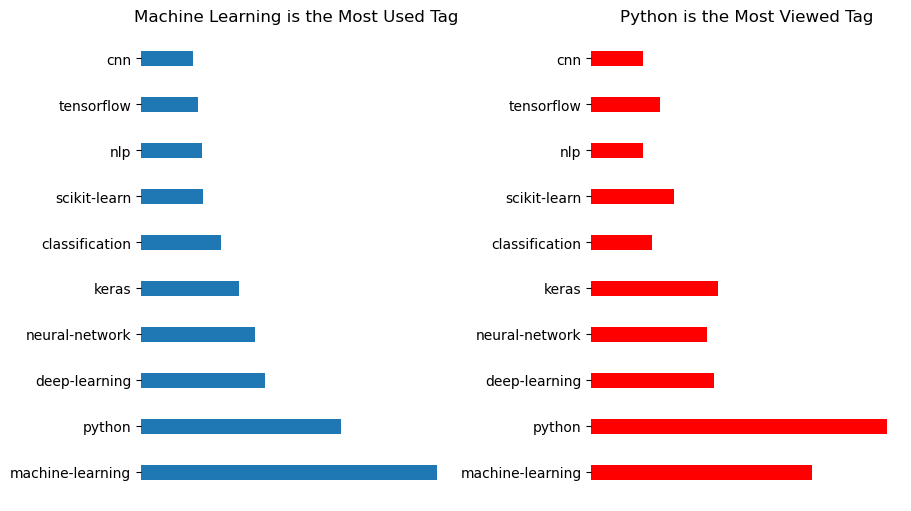

In [11]:
# initializes variables to be used in chart creation
tick_names = top_10_tags.index # stores index of dataframe for y-axis labels
width = .32 # width of horizontal bars
sides = ['top','bottom','right','left'] # list used to turn off chart spines

# initialize layout and variables for plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9,5), layout = "constrained")

# creates chart for tag usage
ax1.barh(tick_names, top_10_tags['times_used'], width)
for s in sides:
    ax1.spines[s].set_visible(False)
ax1.set_xticks([])
ax1.set_title('Machine Learning is the Most Used Tag')

# creates chart for tag viewership
ax2.barh(tick_names, top_10_tags['views'], width, color = 'red')
for s in sides:
    ax2.spines[s].set_visible(False)
ax2.set_xticks([])
ax2.set_title('Python is the Most Viewed Tag')

# Displays charts
plt.show()

After creating our visualization, we can clearly see that, while `machine-learning` is the most frequently used tag used in the dataset and `python` is the second most used tag, that result is flipped in terms of total views. However, we do see that the five most used tags are the five most viewed tags in the dataset.

## Analyzing All Quesitons

Another interesting takeaway from this analysis is that many of these topics are related to the concept of deep learning. To confirm this isn't just a trend for the year 2019, we will run a query in the SQL database that will output the most commonly used tags in questions in the entire database. We will request that query with the following code:

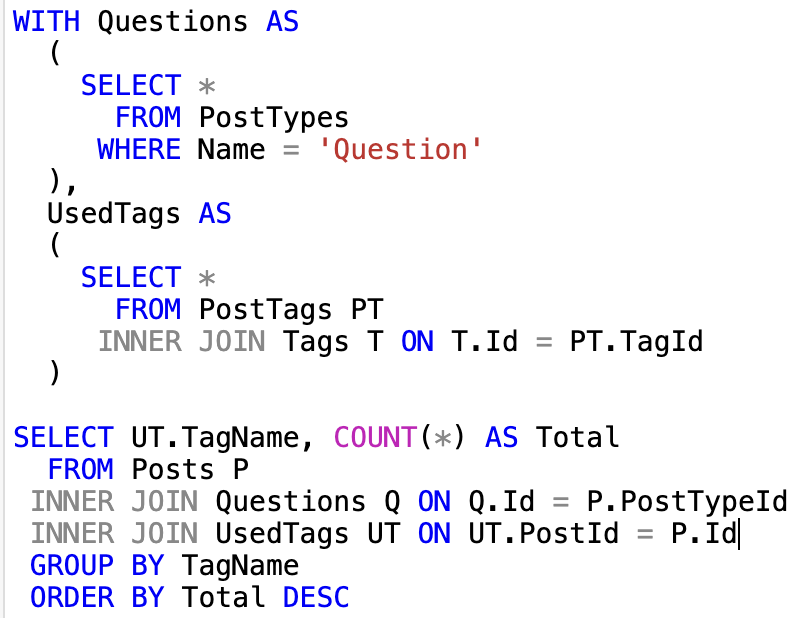

That code produced the file `all_questions.csv`, which we will now read in as a Pandas dataframe and continue our analysis.

In [12]:
# read in dataframe for tag counts for all posts in the stack exchage database
all_questions = pd.read_csv('/Users/ryanehrhardt/Downloads/all_questions.csv')
print(all_questions.head(10))

            TagName  Total
0  machine-learning  11363
1            python   6681
2     deep-learning   4855
3    neural-network   4361
4    classification   3264
5             keras   2726
6               nlp   2712
7      scikit-learn   2300
8        tensorflow   2191
9       time-series   1875


We have now loaded in the dataframe, where the column `total` represents the number of times a tag was used. We can see that many of the tags that appear in the dataframe for the 2019. To see which tags are missing, we will merge the dataframes together. 

In [13]:
# set the index as the tag name for the dataframe to easily merge data
all_questions = all_questions.set_index('TagName')
print(all_questions.head())

                  Total
TagName                
machine-learning  11363
python             6681
deep-learning      4855
neural-network     4361
classification     3264


In [14]:
# left merge top_10_tags on all_questions to see which of the top ten tags from 2019 aren't in the top-10 all time
all_questions = all_questions.merge(top_10_tags, how = 'left', left_index = True, right_index = True)
print(all_questions.head(10))

                  Total  times_used      views
TagName                                       
machine-learning  11363      2129.0  3193336.0
python             6681      1439.0  4274731.0
deep-learning      4855       894.0  1778917.0
neural-network     4361       822.0  1678907.0
classification     3264       577.0   872132.0
keras              2726       704.0  1827414.0
nlp                2712       443.0   752895.0
scikit-learn       2300       448.0  1200831.0
tensorflow         2191       409.0   993233.0
time-series        1875         NaN        NaN


We can see that 9 of the top ten tags in `all_questions` were contained in our top 10 most used tags dataframe from 2019, `top_10_tags`, with the only unincluded tag being `time-series`. This suggests that not only is deep learning a topic people on Stack Exchange are currently deeply interested in, but that they have been interested in this topic for quite some time and will likely have interest in this topic moving forward. Therefore, given the evergreen desire for new information on the topic, shown through both the frequency with which questions were asked on the topic and how often people viewed questions about the topic, it would be prudent for the content creation company to create more content on deep learning topics moving forward.

## Conclusion
The most popular content over the years have been related to topics in deep learning, and that trend hasn't slowed over time. Therefore, it is the official reccommendation that the company create more content surrounding deep learning.